# Ejercicio 2: Agrupamiento jerárquico de Pokémon (Grupo 3C6)

En este ejercicio usamos **agrupamiento jerárquico aglomerativo**, empezamos con cada Pokémon como su propio grupo, vamos uniendo los más parecidos hasta construir una **jerarquía**. La gran ventaja es que además de una partición final, obtenemos un **dendrograma** que muestra cómo se forman los grupos y dónde aparecen “saltos” grandes (uniones a alturas altas), normalmente señal de grupos bien separados.

A lo largo del cuaderno vamos a **preparar los datos** (estadísticas y variables auxiliares), **probar distintas combinaciones de _linkage_ y número de clusters _k_** usando métricas como **Silhouette**, **Davies–Bouldin** y **Calinski–Harabasz**, **interpretar el dendrograma**, **analizar cómo se distribuyen los Pokémon en los grupos**, **comparar esos grupos con los tipos oficiales** y **estudiar en detalle** dónde caen **Zapdos**, **ZapdosGalar** y **Raichu**.

## 1) Imports y configuración básica

In [24]:
# Imports y configuración básica
import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Configuración visual
sns.set()
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)

# Reproducibilidad (para muestreos)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 2) Carga y descripción básica del dataset

Cargamos el fichero **`pokemons.json`**. En nuestra ejecución, el dataset contiene **734 Pokémon** y para cada uno tenemos:
- Un campo `name` (nombre),
- Dos campos, `type1` y `type2` (tipos),
- Variables auxiliares (`hasEvo`, número de tipos, habilidades y movimientos),
- Estadísticas numéricas (`hp`, `atk`, `def`, `spa`, `spd`, `spe`).

In [32]:
# Carga del JSON
path_candidates = ["pokemons.json"]

data_path = None
for p in path_candidates:
    if os.path.exists(p):
        data_path = p
        break

print(f"Dataset encontrado en: {data_path}")

with open(data_path, "r", encoding="utf-8") as f:
    raw = json.load(f)

# Normalización a tabla (DataFrame)
if isinstance(raw, dict) and "pokedex" in raw and isinstance(raw["pokedex"], dict):
    pokedex = raw["pokedex"]
elif isinstance(raw, dict):
    pokedex = raw
elif isinstance(raw, list):
    pokedex = {str(item.get("name", f"pokemon_{i}")): item for i, item in enumerate(raw)}

rows = []
for name, info in pokedex.items():
    info = info if isinstance(info, dict) else {}
    stats = info.get("stats", {}) if isinstance(info.get("stats", {}), dict) else {}
    types = info.get("types", []) if isinstance(info.get("types", []), list) else []
    abilities = info.get("abilities", []) if isinstance(info.get("abilities", []), list) else []
    learnset = info.get("learnset", []) if isinstance(info.get("learnset", []), list) else []

    row = {
        "name": str(name),
        "type1": types[0] if len(types) > 0 else np.nan,
        "type2": types[1] if len(types) > 1 else "None",
        "hasEvo": info.get("hasEvo", np.nan),
        "n_types": len(types),
        "n_abilities": len(abilities),
        "n_moves": len(learnset),
        # stats (si faltan, quedarán como NaN)
        "hp": stats.get("hp", np.nan),
        "atk": stats.get("atk", np.nan),
        "def": stats.get("def", np.nan),
        "spa": stats.get("spa", np.nan),
        "spd": stats.get("spd", np.nan),
        "spe": stats.get("spe", np.nan),
    }
    rows.append(row)

df = pd.DataFrame(rows)
df.head()

Dataset encontrado en: pokemons.json


,name,type1,type2,hasEvo,n_types,n_abilities,n_moves,hp,atk,def,spa,spd,spe
0,bulbasaur,Grass,Poison,1,2,2,57,45,49,49,65,65,45
1,ivysaur,Grass,Poison,1,2,2,52,60,62,63,80,80,60
2,venusaur,Grass,Poison,0,2,2,62,80,82,83,100,100,80
3,charmander,Fire,None,1,1,2,66,39,52,43,60,50,65
4,charmeleon,Fire,None,1,1,2,58,58,64,58,80,65,80


In [33]:
# Estructura del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         734 non-null    object
 1   type1        734 non-null    object
 2   type2        734 non-null    object
 3   hasEvo       734 non-null    int64 
 4   n_types      734 non-null    int64 
 5   n_abilities  734 non-null    int64 
 6   n_moves      734 non-null    int64 
 7   hp           734 non-null    int64 
 8   atk          734 non-null    int64 
 9   def          734 non-null    int64 
 10  spa          734 non-null    int64 
 11  spd          734 non-null    int64 
 12  spe          734 non-null    int64 
dtypes: int64(10), object(3)
memory usage: 74.7+ KB


In [34]:
# Estadísticos descriptivos de variables numéricas
df.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
hasEvo,734.0,0.418256,0.493609,0.0,0.0,0.0,1.0,1.0
n_types,734.0,1.544959,0.498314,1.0,1.0,2.0,2.0,2.0
n_abilities,734.0,2.361035,0.770646,1.0,2.0,3.0,3.0,4.0
n_moves,734.0,53.174387,16.510019,0.0,46.0,53.0,61.0,235.0
hp,734.0,70.539510,28.199599,1.0,50.0,68.0,85.0,255.0
atk,734.0,78.540872,30.708378,5.0,55.0,75.0,100.0,181.0
def,734.0,75.257493,30.775124,5.0,50.0,70.0,95.0,230.0
spa,734.0,71.779292,30.869621,10.0,50.0,65.0,95.0,173.0
spd,734.0,72.600817,27.690948,20.0,50.0,70.0,90.0,230.0
spe,734.0,67.367847,29.341353,5.0,45.0,65.0,90.0,200.0


A partir de estas salidas podemos extraer varias ideas clave: el dataset tiene **734 filas y 13 columnas**, de las cuales **10 son numéricas** (todas `int64`) y **3 categóricas** (`name`, `type1`, `type2`). En el resumen estadístico observamos rangos razonables para las estadísticas de combate: por ejemplo, `hp` tiene una media de aproximadamente **70.54** con un máximo de **255**, `atk` una media cercana a **78.54** (máximo **181**) y `spe` una media de alrededor de **67.37** (máximo **200**). La columna `n_moves` llama la atención porque su media ronda los **53.17** pero alcanza un máximo de **235**, lo que sugiere la presencia de **outliers** (Pokémon con muchísimos movimientos registrados en el dataset); en el contexto de clustering jerárquico estos valores extremos pueden distorsionar las distancias y “romper” los grupos si no los tratamos adecuadamente. Con estas observaciones claras, el siguiente paso será preparar la **matriz de variables** que usaremos para el agrupamiento.

## 3) Preparación de datos para clustering

Para poder agrupar por distancias necesitamos construir una matriz de características **X**. En una primera aproximación vamos a utilizar las estadísticas básicas (`hp`, `atk`, `def`, `spa`, `spd`, `spe`), algunas variables auxiliares (`hasEvo`, `n_moves`, `n_abilities`, `n_types`) y los **tipos** (`type1`, `type2`), que convertimos mediante *one-hot encoding* para que puedan entrar en el modelo. 

Aplicamos **imputación simple** por si existieran valores perdidos, de forma que el algoritmo no falle al encontrar `NaN`; usamos **one-hot encoding en los tipos** para que la información de tipo elemental influya en el cálculo de distancias sin tener que inventar códigos numéricos arbitrarios y aplicamos **escalado** con `StandardScaler`, algo muy importante en algoritmos basados en distancias, porque si no escalamos, cualquier variable con un rango grande podría dominar el cálculo y arrastrar todo el clustering. 

Con esta combinación de estadísticas, variables auxiliares y tipos codificados, en esta ejecución terminamos con una matriz de **47 variables** que usaremos como base para el proceso de agrupamiento.

In [35]:
# Selección de columnas
numeric_cols = ["hp", "atk", "def", "spa", "spd", "spe", "hasEvo", "n_moves", "n_abilities", "n_types"]
cat_cols = ["type1", "type2"]

df_prep = df.copy()

# Limpieza básica de categorías
df_prep["type1"] = df_prep["type1"].fillna("Unknown").astype(str)
df_prep["type2"] = df_prep["type2"].fillna("None").astype(str)

# Imputación simple numérica (mediana)
for c in numeric_cols:
    med = df_prep[c].median(numeric_only=True)
    df_prep[c] = pd.to_numeric(df_prep[c], errors="coerce").fillna(med)

# One-hot encoding para los tipos
df_types = pd.get_dummies(df_prep[cat_cols], prefix=cat_cols, dummy_na=False)

# Matriz final de features
X_df = pd.concat([df_prep[numeric_cols], df_types], axis=1)

print(f"Nº de filas (Pokémon): {X_df.shape[0]}")
print(f"Nº de variables para clustering: {X_df.shape[1]}")
X_df.head()

Nº de filas (Pokémon): 734
Nº de variables para clustering: 47


,hp,atk,def,spa,spd,spe,hasEvo,n_moves,n_abilities,n_types,type1_Bug,type1_Dark,type1_Dragon,type1_Electric,type1_Fairy,type1_Fighting,type1_Fire,type1_Flying,type1_Ghost,type1_Grass,type1_Ground,type1_Ice,type1_Normal,type1_Poison,type1_Psychic,type1_Rock,type1_Steel,type1_Water,type2_Bug,type2_Dark,type2_Dragon,type2_Electric,type2_Fairy,type2_Fighting,type2_Fire,type2_Flying,type2_Ghost,type2_Grass,type2_Ground,type2_Ice,type2_None,type2_Normal,type2_Poison,type2_Psychic,type2_Rock,type2_Steel,type2_Water
0,45,49,49,65,65,45,1,57,2,2,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,60,62,63,80,80,60,1,52,2,2,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
2,80,82,83,100,100,80,0,62,2,2,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,39,52,43,60,50,65,1,66,2,1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
4,58,64,58,80,65,80,1,58,2,1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


In [36]:
# Escalado (clave en clustering por distancias)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df.values)

# Muestra de las 3 primeras filas ya escaladas (valores tipo z-score)
X_scaled[:3]

array([[-0.90628681, -0.96263684, -0.85378692, -0.21976021, -0.27467461,
        -0.76285167,  1.17935554,  0.23187264, -0.46880338,  0.91378334,
        -0.24007684, -0.22038927, -0.22376669, -0.27612739, -0.1539802 ,
        -0.21350421, -0.23366151, -0.10497278, -0.22376669,  3.47953199,
        -0.22710335, -0.22376669, -0.29564744, -0.20999221, -0.29564744,
        -0.2463608 , -0.21350421, -0.3809013 , -0.1114172 , -0.1539802 ,
        -0.19542142, -0.10497278, -0.23040106, -0.16301358, -0.12892051,
        -0.31170489, -0.17985773, -0.16736548, -0.19914833, -0.14443791,
        -0.91378334, -0.09812548,  5.43905629, -0.20643071, -0.13944334,
        -0.19542142, -0.15855493],
       [-0.37400164, -0.53901092, -0.39856384,  0.26648575,  0.26738803,
        -0.2512792 ,  1.17935554, -0.07118028, -0.46880338,  0.91378334,
        -0.24007684, -0.22038927, -0.22376669, -0.27612739, -0.1539802 ,
        -0.21350421, -0.23366151, -0.10497278, -0.22376669,  3.47953199,
        -0.22710

En la salida de `X_scaled[:3]` se ven valores positivos y negativos: eso es normal tras `StandardScaler`.
La interpretación es: *cuántas desviaciones típicas* está cada valor respecto a la media. Esto hace comparables variables muy distintas (por ejemplo `hp` y las columnas de one-hot).

## 4) Búsqueda de (linkage, k) con métricas

A continuación probamos varios criterios de enlace (**linkage**) y distintos números de clusters `k`. En concreto, usamos `single`, que tiende a formar “cadenas” porque siempre une los puntos más cercanos; `complete`, que favorece grupos más compactos al basarse en la distancia entre los puntos más lejanos; `average`, que busca un equilibrio calculando distancias medias; y `ward`, que intenta minimizar la varianza interna de los clusters y suele funcionar bien cuando los datos numéricos están escalados.

Para comparar las distintas configuraciones utilizamos varias métricas: **Silhouette**, donde valores más altos indican una mejor separación entre grupos; **Davies–Bouldin**, donde valores más bajos son preferibles; y **Calinski–Harabasz**, donde valores más altos suelen asociarse a una estructura de clusters más clara. Es importante tener en cuenta que una métrica “buena” no garantiza por sí sola que la solución sea realmente útil, por lo que más adelante también revisaremos los **tamaños de los clusters** para evitar soluciones triviales, como aquellas en las que uno de los grupos contiene solo un Pokémon.

In [38]:
def make_agglomerative(n_clusters, linkage_name):
    """Crea un modelo AgglomerativeClustering compatible con distintas versiones de scikit-learn."""
    try:
        return AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_name, metric="euclidean")
    except TypeError:
        return AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_name, affinity="euclidean")

linkages = ["single", "complete", "average", "ward"]
k_values = list(range(2, 9))

results = []
for link in linkages:
    for k in k_values:
        model = make_agglomerative(k, link)
        labels = model.fit_predict(X_scaled)

        n_unique = len(np.unique(labels))
        sil = np.nan if (n_unique < 2 or n_unique >= X_scaled.shape[0]) else silhouette_score(X_scaled, labels, metric="euclidean")
        dbi = davies_bouldin_score(X_scaled, labels) if n_unique >= 2 else np.nan
        chi = calinski_harabasz_score(X_scaled, labels) if n_unique >= 2 else np.nan

        results.append({
            "linkage": link,
            "k": k,
            "n_clusters_real": n_unique,
            "silhouette": sil,
            "davies_bouldin": dbi,
            "calinski_harabasz": chi
        })

res_df = pd.DataFrame(results)
res_df.sort_values(["silhouette"], ascending=False).head(10)

,linkage,k,n_clusters_real,silhouette,davies_bouldin,calinski_harabasz
14,average,2,2,0.314469,0.548707,3.114683
7,complete,2,2,0.314469,0.548707,3.114683
0,single,2,2,0.297647,0.983403,17.444333
15,average,3,3,0.287635,0.836696,10.341159
2,single,4,4,0.276501,1.069657,17.925883
1,single,3,3,0.274835,1.075024,17.428876
16,average,4,4,0.272322,0.915853,12.973157
17,average,5,5,0.272209,0.962520,14.319568
3,single,5,5,0.267295,1.093958,18.366744
18,average,6,6,0.263692,0.999933,15.422061


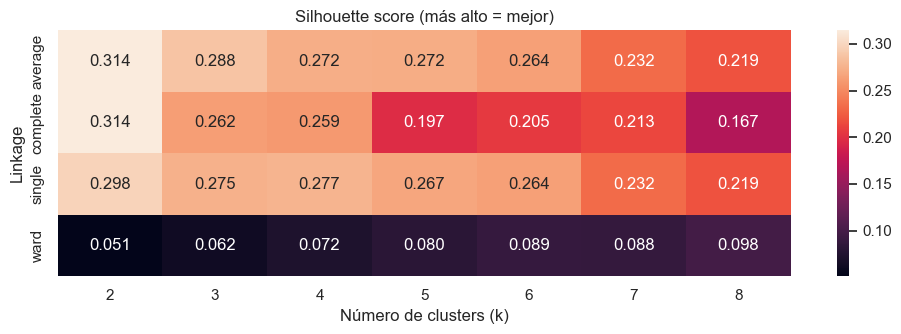

In [39]:
# Heatmap de Silhouette para comparar rápidamente (linkage vs k)
pivot_sil = res_df.pivot_table(index="linkage", columns="k", values="silhouette", aggfunc="mean")

plt.figure(figsize=(10, 3.5))
sns.heatmap(pivot_sil, annot=True, fmt=".3f")
plt.title("Silhouette score (más alto = mejor)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Linkage")
plt.tight_layout()
plt.show()

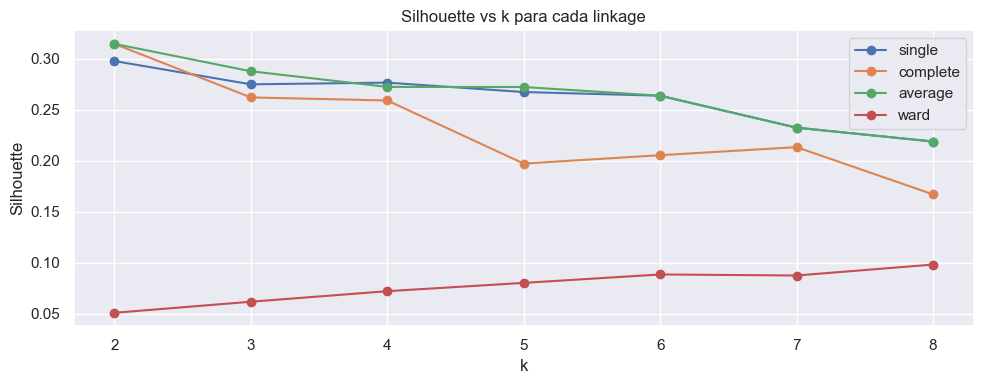

In [40]:
# Curvas de Silhouette por linkage
plt.figure(figsize=(10, 4))
for link in linkages:
    tmp = res_df[res_df["linkage"] == link].sort_values("k")
    plt.plot(tmp["k"], tmp["silhouette"], marker="o", label=link)

plt.title("Silhouette vs k para cada linkage")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

A partir de los resultados que se observan en la tabla y en las gráficas, vemos que el valor máximo de Silhouette aparece en **k = 2** con `complete` o `average`, con un valor aproximado de **0.314**. Cuando pasamos a **k = 3**, la calidad medida por Silhouette baja ligeramente (por ejemplo, `average` se queda alrededor de **0.288**), lo que indica que añadir un tercer grupo no mejora la separación entre clusters. El método `ward` se queda bastante por debajo en esta configuración (valores en torno a 0.05–0.10), lo que sugiere que no está encajando tan bien con la combinación de variables numéricas y variables codificadas con one-hot que estamos usando.

Si nos guiamos únicamente por las métricas, el “mejor” modelo sería `complete` con **k = 2** (empata con `average`, y decidimos desempatar a favor de `complete`), pero antes de aceptar esta solución como definitiva conviene revisar si la partición es realmente **útil**, analizando los tamaños de los clusters y su contenido para descartar soluciones demasiado desequilibradas o poco interpretables.

In [10]:
# Selección automática: Silhouette (más alto) y desempate con Davies-Bouldin (más bajo)
cand = res_df[res_df["silhouette"].notna()].copy()
cand["silhouette_rank"] = cand["silhouette"].rank(ascending=False, method="min")
cand["db_rank"] = cand["davies_bouldin"].rank(ascending=True, method="min")
cand["score"] = cand["silhouette_rank"] * 1000 + cand["db_rank"]

best_row = cand.sort_values("score").iloc[0]
best_linkage = best_row["linkage"]
best_k = int(best_row["k"])
best_row

linkage              complete
k                           2
n_clusters_real             2
silhouette           0.314469
davies_bouldin       0.548707
calinski_harabasz    3.114683
silhouette_rank           1.0
db_rank                   1.0
score                  1001.0
Name: 7, dtype: object

## 5) Dendrograma (modelo candidato por métricas)

El dendrograma nos muestra la **jerarquía** de fusiones entre Pokémon, pero en datasets grandes puede volverse ilegible, por lo que utilizamos un **dendrograma truncado** que solo enseña las uniones finales entre los grupos más grandes. Para leerlo hay que fijarse en que la altura a la que se unen las ramas representa la **distancia** entre clusters (cuanto más alta es la unión, más diferentes son los grupos que se están fusionando); cuando aparece un **salto grande** en esa altura suele ser un buen candidato para decidir dónde “cortar” el árbol y definir el número de clusters. Además, dibujamos una línea de referencia que indica aproximadamente el nivel de corte que generaría `k` grupos, lo que sirve como guía visual para relacionar el dendrograma con el número de clusters que estamos considerando.

Modelo candidato -> linkage: complete | k: 2
Dendrograma con muestreo: True (n=200)


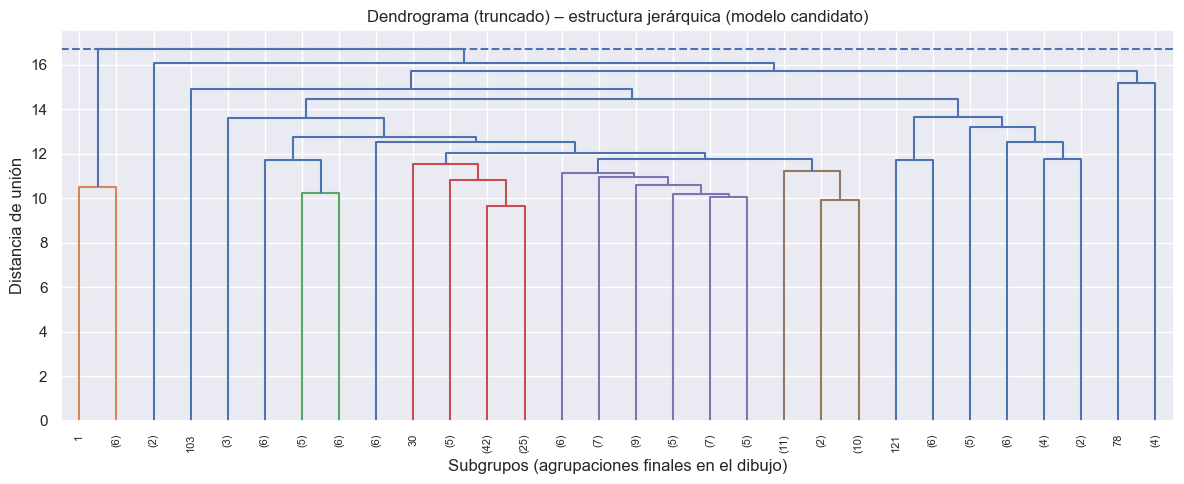

In [42]:
# Dendrograma (posible muestreo para que sea legible)
n_samples = X_scaled.shape[0]
max_for_plot = 200

if n_samples > max_for_plot:
    idx = np.random.choice(n_samples, size=max_for_plot, replace=False)
    X_plot = X_scaled[idx]
    sampled = True
else:
    X_plot = X_scaled
    sampled = False

print(f"Modelo candidato -> linkage: {best_linkage} | k: {best_k}")
print("Dendrograma con muestreo:", sampled, f"(n={X_plot.shape[0]})")

Z = linkage(X_plot, method=best_linkage)

# Distancia aproximada para 'cortar' en k clusters (referencia visual)
cut_distance = Z[-(best_k - 1), 2] if best_k <= X_plot.shape[0] else np.nan

plt.figure(figsize=(12, 5))
dendrogram(
    Z,
    labels=None,
    leaf_rotation=90,
    leaf_font_size=8,
    truncate_mode="lastp",
    p=30,
    show_leaf_counts=True
)
if not np.isnan(cut_distance):
    plt.axhline(y=cut_distance, linestyle="--")
plt.title("Dendrograma (truncado) – estructura jerárquica (modelo candidato)")
plt.xlabel("Subgrupos (agrupaciones finales en el dibujo)")
plt.ylabel("Distancia de unión")
plt.tight_layout()
plt.show()

## 6) Asignación final del modelo candidato y distribución de tamaños

Aquí respondemos a lo anterior, que consiste en ver **cómo se distribuyen los Pokémon en los distintos grupos**. Para ello utilizamos un **gráfico de barras** ya que permite comparar de un vistazo cuántos elementos hay en cada cluster y detectar rápidamente si la solución está muy desbalanceada (por ejemplo, un grupo enorme y varios casi vacíos) o si los tamaños son relativamente equilibrados.

In [43]:
# Entrenamiento final (modelo candidato) con todos los datos
candidate_model = make_agglomerative(best_k, best_linkage)
candidate_labels = candidate_model.fit_predict(X_scaled)

df_candidate = df_prep.copy()
df_candidate["cluster"] = candidate_labels

counts_candidate = df_candidate["cluster"].value_counts().sort_index()
counts_candidate

cluster
0    733
1      1
Name: count, dtype: int64

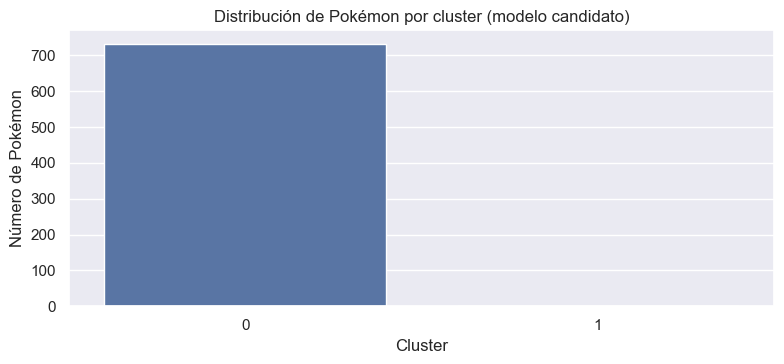

In [44]:
# Visualización: distribución de tamaños por cluster (modelo candidato)
counts = counts_candidate

plt.figure(figsize=(8, 3.8))
sns.barplot(x=counts.index, y=counts.values)
plt.title("Distribución de Pokémon por cluster (modelo candidato)")
plt.xlabel("Cluster")
plt.ylabel("Número de Pokémon")
plt.tight_layout()
plt.show()

En esta ejecución ocurre algo importante, el modelo candidato con `complete` y `k = 2` produce una distribución **muy desbalanceada**, donde un cluster agrupa **733 Pokémon** y el otro contiene solo **1 Pokémon**. Esta situación explica por qué el dendrograma sugiere un corte tan “fuerte”, el algoritmo está separando un **outlier** del resto del conjunto. Para entender mejor lo que está pasando, conviene identificar qué Pokémon ha caído en ese cluster de tamaño 1 y analizar qué características tiene para justificar que se aleje tanto del resto en el espacio de características.

In [45]:
# ¿Quién está en el cluster pequeño (tamaño 1)?
small_clusters = counts_candidate[counts_candidate <= 5].index.tolist()
print("Clusters pequeños (<=5 elementos):", small_clusters)

df_candidate[df_candidate["cluster"].isin(small_clusters)][
    ["name", "type1", "type2", "hp", "atk", "def", "spa", "spd", "spe", "n_moves", "n_abilities", "hasEvo", "cluster"]
].sort_values(["cluster", "n_moves"], ascending=[True, False]).head(20)

Clusters pequeños (<=5 elementos): [1]


,name,type1,type2,hp,atk,def,spa,spd,spe,n_moves,n_abilities,hasEvo,cluster
146,mew,Psychic,None,100,100,100,100,100,100,235,1,0,1


En nuestra ejecución, el cluster de un solo elemento corresponde a **Mew** (tipo `Psychic`), que destaca por tener `n_moves = 235`, un valor muy por encima de la media (alrededor de 53), y unas estadísticas muy “redondas”, con **100 en todas las stats** en este dataset. En resumen, este modelo candidato resulta útil para **detectar un outlier muy claro**, pero **no es práctico** si nuestro objetivo es descubrir varios grupos funcionales de Pokémon, porque prácticamente coloca a todos en el mismo cluster y deja solo a Mew separado. Dado que el enunciado nos pide analizar grupos, tipos y casos concretos como **Zapdos**, **ZapdosGalar** y **Raichu**, a partir de aquí construiremos un **modelo final más interpretativo**, que genere varios clusters con contenido más equilibrado y fácil de analizar.

## 7) Modelo final para análisis funcional (decisión justificada)

Para que el clustering sea más informativo, ajustamos la representación de los datos: en primer lugar **quitamos `n_moves`** del proceso de agrupamiento, porque en este dataset introduce outliers muy fuertes (como Mew) y tiende a generar clusters de tamaño 1; después nos centramos en variables **funcionales de combate**, utilizando las estadísticas básicas (`hp`, `atk`, `def`, `spa`, `spd`, `spe`) y añadiendo `hasEvo`, `n_abilities` y `n_types` como contexto adicional ligero, por último, dejamos los **tipos elementales** fuera de la medida de distancia y los reservamos para la fase de comparación e interpretación de los grupos.

Con esta representación, un criterio razonable es usar `ward`, que minimiza la varianza interna de los clusters, y buscar un valor de `k` que no produzca grupos ridículamente pequeños y que siga siendo interpretable a la vista del dendrograma. En la práctica, trabajaremos con **k = 3**, porque nos proporciona tres perfiles funcionales claros (bajo, medio y alto rendimiento en stats) y un reparto de Pokémon relativamente equilibrado entre los grupos.

In [46]:
# Matriz funcional (sin n_moves y sin one-hot de tipos)
core_numeric_cols = ["hp", "atk", "def", "spa", "spd", "spe", "hasEvo", "n_abilities", "n_types"]

X_core = df_prep[core_numeric_cols].copy()
X_core_scaled = StandardScaler().fit_transform(X_core.values)

# Comprobación rápida: evaluación solo para ward (para decidir k)
core_eval = []
for k in range(2, 9):
    m = make_agglomerative(k, "ward")
    lab = m.fit_predict(X_core_scaled)
    sil = silhouette_score(X_core_scaled, lab)
    vc = pd.Series(lab).value_counts()
    core_eval.append({"k": k, "silhouette": sil, "min_size": int(vc.min()), "max_size": int(vc.max())})

core_eval_df = pd.DataFrame(core_eval)
core_eval_df

,k,silhouette,min_size,max_size
0,2,0.284200,313,421
1,3,0.223158,110,313
2,4,0.164766,110,311
3,5,0.174239,110,179
4,6,0.180966,14,179
5,7,0.177145,14,179
6,8,0.158424,14,134


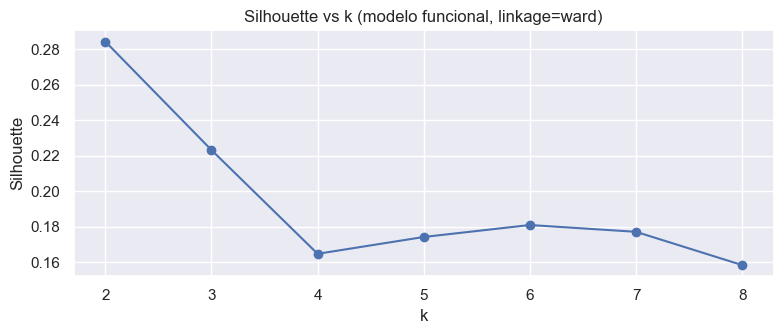

In [47]:
# Visualización: silhouette vs k (modelo funcional con ward)
plt.figure(figsize=(8, 3.5))
plt.plot(core_eval_df["k"], core_eval_df["silhouette"], marker="o")
plt.title("Silhouette vs k (modelo funcional, linkage=ward)")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.grid(True)
plt.tight_layout()
plt.show()

Aunque el valor de Silhouette suele ser algo mayor para `k = 2`, en este caso elegimos **k = 3** porque ofrece un mejor equilibrio entre varios aspectos: en términos de **interpretación**, resulta más sencillo explicar tres perfiles funcionales distintos; en cuanto al **reparto**, evitamos tener clusters diminutos o casi vacíos; y, si miramos el **dendrograma**, podemos identificar tres ramas principales que tienen sentido como grupos separados. Con esta decisión tomada, generamos el dendrograma usando el criterio `ward` y dibujamos una línea de corte que corresponde a `k = 3`.

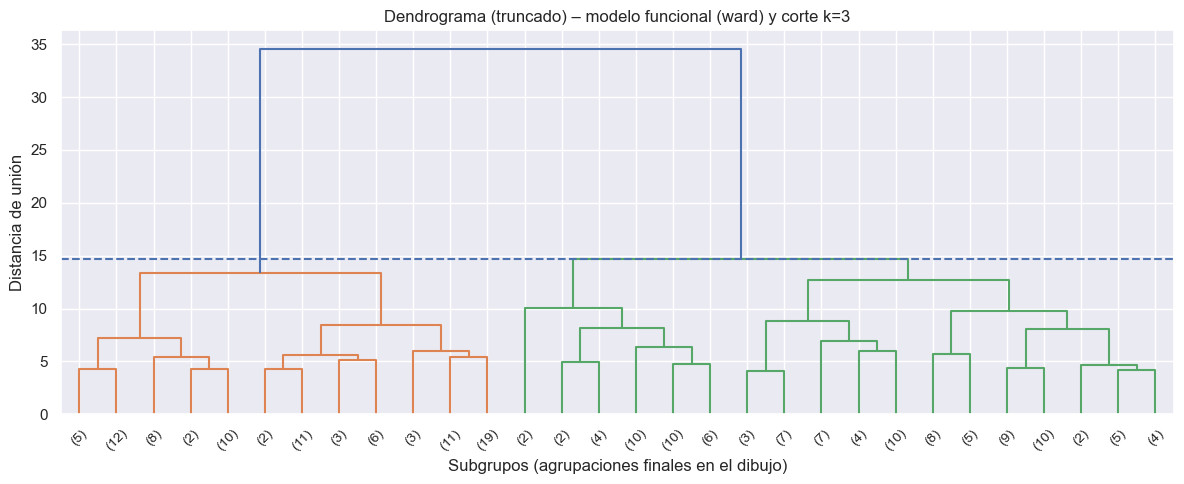

In [48]:
# Dendrograma del modelo funcional (ward) con muestreo para legibilidad
n_samples = X_core_scaled.shape[0]
max_for_plot = 200

if n_samples > max_for_plot:
    idx = np.random.choice(n_samples, size=max_for_plot, replace=False)
    X_plot = X_core_scaled[idx]
    sampled = True
else:
    X_plot = X_core_scaled
    sampled = False

Z_core = linkage(X_plot, method="ward")
k_final = 3
cut_distance = Z_core[-(k_final - 1), 2] if k_final <= X_plot.shape[0] else np.nan

plt.figure(figsize=(12, 5))
dendrogram(
    Z_core,
    truncate_mode="lastp",
    p=30,
    show_leaf_counts=True
)
if not np.isnan(cut_distance):
    plt.axhline(y=cut_distance, linestyle="--")
plt.title("Dendrograma (truncado) – modelo funcional (ward) y corte k=3")
plt.xlabel("Subgrupos (agrupaciones finales en el dibujo)")
plt.ylabel("Distancia de unión")
plt.tight_layout()
plt.show()

## 8) Asignación final (modelo funcional) y distribución

Esta gráfica representa la respuesta principal a la pregunta sobre la **distribución de los Pokémon por grupos** y será la referencia que utilizaremos en el resto del análisis. De nuevo recurrimos a un **gráfico de barras**, porque es la forma más clara y directa de comparar los tamaños de cada cluster y comprobar si el reparto entre ellos es razonablemente equilibrado o si alguno concentra demasiados elementos respecto a los demás.

In [49]:
# Entrenamiento final (modelo funcional)
final_linkage = "ward"
final_k = 3

final_model = make_agglomerative(final_k, final_linkage)
final_labels = final_model.fit_predict(X_core_scaled)

df_final = df_prep.copy()
df_final["cluster"] = final_labels

counts_final = df_final["cluster"].value_counts().sort_index()
counts_final

cluster
0    313
1    311
2    110
Name: count, dtype: int64

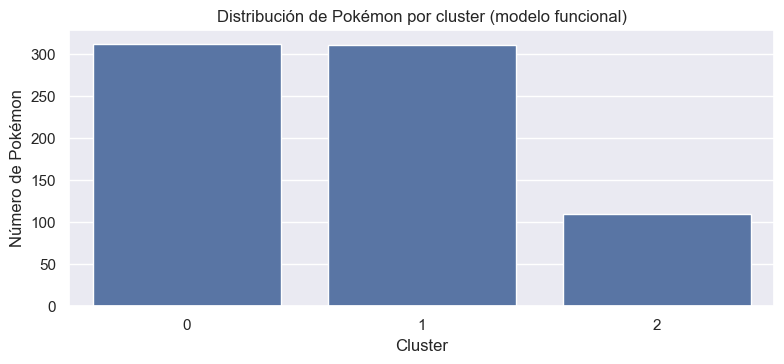

In [50]:
# Visualización: distribución de tamaños por cluster (modelo funcional)
counts = counts_final

plt.figure(figsize=(8, 3.8))
sns.barplot(x=counts.index, y=counts.values)
plt.title("Distribución de Pokémon por cluster (modelo funcional)")
plt.xlabel("Cluster")
plt.ylabel("Número de Pokémon")
plt.tight_layout()
plt.show()

Con este modelo los clusters quedan bastante repartidos (en nuestra ejecución obtenemos grupos de **313**, **311** y **110** Pokémon), lo que supone una mejora clara frente al modelo candidato anterior, donde teníamos una partición de **733** frente a **1**. Esta nueva distribución es mucho más útil para **interpretar grupos funcionales**, porque cada cluster tiene un tamaño suficiente como para extraer patrones y comparar perfiles sin que el análisis quede dominado por un único grupo gigantesco o por outliers aislados.

## 9) Relación con tipos oficiales y grupos funcionales

Ahora comparamos los clusters con `type1` (tipo principal) y utilizamos un **heatmap** porque nos permite ver de forma visual qué tipos se concentran en cada grupo y con qué intensidad. Este tipo de gráfica ayuda a detectar rápidamente patrones, como si un cluster está dominado por uno o varios tipos elementales concretos o si, por el contrario, mezcla muchos tipos distintos pero que comparten un mismo rol funcional. De esta manera podemos relacionar la estructura de clusters obtenida a partir de las estadísticas con la clasificación oficial por tipos y comprobar hasta qué punto coinciden o divergen.

In [51]:
# Tabla cruzada cluster x tipo principal
ct = pd.crosstab(df_final["cluster"], df_final["type1"])
ct

type1,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
cluster,,,,,,,,,,,,,,,,,,
0,19,15,14,20,7,11,16,3,16,28,16,14,28,15,21,17,11,42
1,17,14,8,19,7,17,17,3,13,25,15,18,29,14,22,17,13,43
2,4,5,13,13,3,4,5,2,6,3,5,3,2,2,16,8,8,8


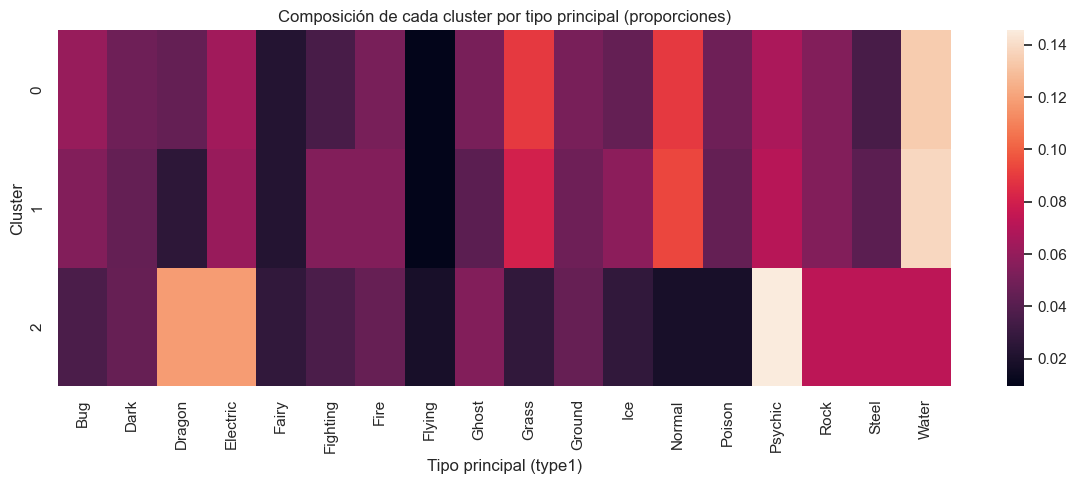

In [52]:
# Heatmap (normalizado por fila para ver composición de cada cluster)
ct_norm = ct.div(ct.sum(axis=1), axis=0)

plt.figure(figsize=(12, 5))
sns.heatmap(ct_norm)
plt.title("Composición de cada cluster por tipo principal (proporciones)")
plt.xlabel("Tipo principal (type1)")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

En nuestra ejecución no aparece ningún cluster que sea “equivalente” a un tipo elemental concreto; en general, cada grupo mezcla varios tipos distintos, lo que sugiere que lo que estamos agrupando aquí es sobre todo el **perfil de estadísticas y el rol funcional** de los Pokémon, y no su tipo oficial. Esto responde a la pregunta de evaluación: los grupos resultantes pueden **diferir** de los tipos oficiales, porque dos Pokémon con tipos distintos pueden desempeñar un papel muy parecido y acabar en el mismo cluster debido a que sus stats y características funcionales son similares.

## 10) Análisis de Zapdos, ZapdosGalar y Raichu

Primero localizamos esos Pokémon por nombre y comprobamos sus estadísticas junto con el cluster al que pertenecen. A continuación añadimos una visualización en la que comparamos sus stats con la **media de su propio cluster** mediante una gráfica de líneas, porque este tipo de gráfico permite ver de forma muy clara en qué estadísticas cada uno de ellos está por encima o por debajo del “perfil típico” de su grupo.

In [53]:
def canonicalize(name):
    return re.sub(r"[^a-z0-9]+", "", str(name).lower())

df_final = df_final.copy()
df_final["name_key"] = df_final["name"].map(canonicalize)

targets = {
    "Zapdos": ["zapdos"],
    "ZapdosGalar": ["zapdosgalar", "zapdosgalarian", "zapdos-galar", "zapdos galar"],
    "Raichu": ["raichu"]
}

found_rows = []
for label, variants in targets.items():
    variant_keys = [canonicalize(v) for v in variants]
    match = df_final[df_final["name_key"].isin(variant_keys)]
    if match.empty:
        key_main = variant_keys[0]
        match = df_final[df_final["name_key"].str.contains(key_main, na=False)]
    if match.empty:
        print(f"No encontrado: {label}. Revisa el nombre exacto en df_final['name']")
        continue
    row = match.iloc[0].copy()
    row["target_label"] = label
    found_rows.append(row)

focus = pd.DataFrame(found_rows)
cols_show = ["target_label", "name", "type1", "type2", "hp", "atk", "def", "spa", "spd", "spe", "cluster"]
focus[cols_show]

,target_label,name,type1,type2,hp,atk,def,spa,spd,spe,cluster
138,Zapdos,zapdos,Electric,Flying,90,90,85,125,90,100,1
139,ZapdosGalar,zapdosgalar,Fighting,Flying,90,125,90,85,90,100,2
21,Raichu,raichu,Electric,None,60,90,55,90,80,110,1


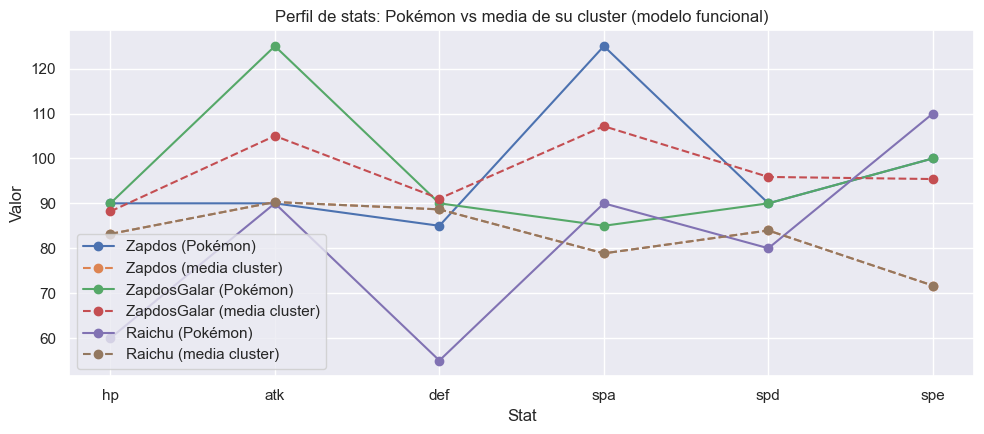

In [54]:
# Visualización: Pokémon vs media de su cluster (solo stats de combate)
stats_cols = ["hp", "atk", "def", "spa", "spd", "spe"]

if not focus.empty:
    cluster_means = df_final.groupby("cluster")[stats_cols].mean()
    plot_rows = []
    for _, r in focus.iterrows():
        c = int(r["cluster"])
        for s in stats_cols:
            plot_rows.append({"who": r["target_label"], "stat": s, "value": float(r[s]), "kind": "Pokémon"})
            plot_rows.append({"who": r["target_label"], "stat": s, "value": float(cluster_means.loc[c, s]), "kind": "Media cluster"})
    plot_df = pd.DataFrame(plot_rows)

    plt.figure(figsize=(10, 4.5))
    for who in plot_df["who"].unique():
        tmp = plot_df[(plot_df["who"] == who) & (plot_df["kind"] == "Pokémon")]
        tmp2 = plot_df[(plot_df["who"] == who) & (plot_df["kind"] == "Media cluster")]
        plt.plot(tmp["stat"], tmp["value"], marker="o", label=f"{who} (Pokémon)")
        plt.plot(tmp2["stat"], tmp2["value"], marker="o", linestyle="--", label=f"{who} (media cluster)")

    plt.title("Perfil de stats: Pokémon vs media de su cluster (modelo funcional)")
    plt.xlabel("Stat")
    plt.ylabel("Valor")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No se han encontrado los Pokémon objetivo. Revisa los nombres en la columna 'name'.")

En nuestra ejecución observamos que **Zapdos** y **Raichu** caen en el mismo cluster, lo que indica que comparten un perfil funcional similar como atacantes rápidos, con un peso importante del ataque especial. En cambio, **ZapdosGalar** aparece en un cluster distinto, algo coherente con su perfil más orientado al **ataque físico** (en el dataset presenta un `atk` más alto que el de Zapdos) y un rol algo diferente en combate.

Esto sugiere que, según las variables que hemos utilizado (principalmente las estadísticas de combate), **Zapdos y Raichu son funcionalmente más parecidos entre sí** que Zapdos y su variante de Galar. Es un buen ejemplo de cómo el clustering basado en funciones y stats no tiene por qué coincidir exactamente con la taxonomía oficial por tipos: aunque Zapdos y Raichu comparten tipo Eléctrico, el algoritmo está agrupando según el “perfil” estadístico y no según el tipo elemental.

## 11) Conclusiones del Ejercicio 2

En esta práctica vimos que, si solo mirábamos la métrica Silhouette con la representación “completa” (stats + tipos one-hot + `n_moves`), el mejor resultado aparecía en **k = 2** con `complete` o `average` (Silhouette ≈ **0.314**). Sin embargo, esa partición terminaba siendo de **733 Pokémon en un cluster y 1 en otro**, separando a **Mew** como outlier debido a su `n_moves = 235` y sus stats de 100 en todo. Aunque esto tiene sentido como detección de valores extremos, no es útil para analizar varios grupos funcionales.

Por ese motivo, para el análisis funcional adoptamos una representación más estable, eliminando `n_moves` de la distancia y dejando los tipos fuera del espacio de clustering. Con esta nueva representación utilizamos el criterio `ward` y trabajamos con **k = 3**, lo que nos dio clusters mucho más equilibrados (**313**, **311** y **110** Pokémon) y un dendrograma claramente interpretable. La siguiente figura resume el **perfil medio de estadísticas por cluster**, expresado en z-score, para ver de forma directa qué grupos se sitúan por encima o por debajo de la media global en cada stat.

In [ ]:
# Plot de conclusiones: perfil medio por cluster (en z-score)
stats_cols = ["hp", "atk", "def", "spa", "spd", "spe"]

# Media por cluster
cluster_means = df_final.groupby("cluster")[stats_cols].mean()

# Pasamos a z-score por columna para comparar "por encima/debajo" de la media global
cluster_means_z = (cluster_means - cluster_means.mean(axis=0)) / cluster_means.std(axis=0)

plt.figure(figsize=(8, 3.5))
sns.heatmap(cluster_means_z, annot=True, fmt=".2f")
plt.title("Perfil medio por cluster (z-score sobre stats)")
plt.xlabel("Stat")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

En cuanto a la relación con los tipos oficiales, los clusters **no se corresponden uno a uno con un tipo elemental**. Dentro de cada grupo se mezclan varios tipos, lo que indica que el agrupamiento está capturando principalmente **roles funcionales basados en las estadísticas**, más que las categorías oficiales por tipo. Es decir, Pokémon de tipos distintos pueden acabar juntos si su perfil de stats es parecido.

Respecto al uso de agrupamiento jerárquico en este contexto, una de las grandes **ventajas** es que el dendrograma permite visualizar tanto outliers (como el caso de Mew) como la estructura global de las fusiones entre grupos. La **desventaja** principal es su sensibilidad a la representación y a la presencia de valores extremos: si incluimos variables con rangos muy desbalanceados (como `n_moves`), el algoritmo puede producir soluciones triviales o poco útiles, como clusters de tamaño 1 que no ayudan a describir el conjunto de datos de forma general.

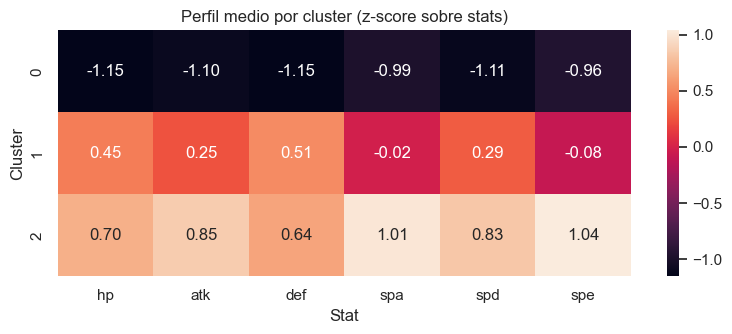

In [57]:
# Plot de conclusiones: perfil medio por cluster (en z-score)
stats_cols = ["hp", "atk", "def", "spa", "spd", "spe"]

# Media por cluster
cluster_means = df_final.groupby("cluster")[stats_cols].mean()

# Pasamos a z-score por columna para comparar "por encima/debajo" de la media global
cluster_means_z = (cluster_means - cluster_means.mean(axis=0)) / cluster_means.std(axis=0)

plt.figure(figsize=(8, 3.5))
sns.heatmap(cluster_means_z, annot=True, fmt=".2f")
plt.title("Perfil medio por cluster (z-score sobre stats)")
plt.xlabel("Stat")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


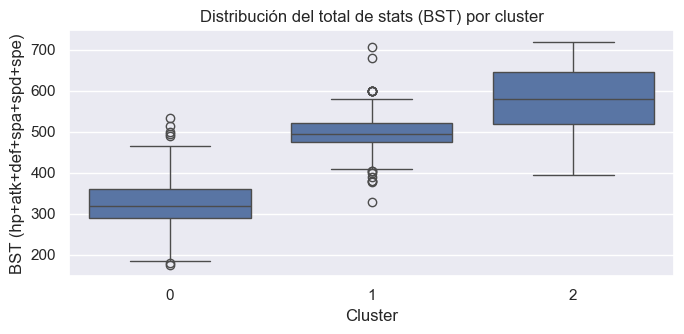

In [58]:
# Plot de conclusiones: distribución del total de stats (BST) por cluster
stats_cols = ["hp", "atk", "def", "spa", "spd", "spe"]

df_tmp = df_final.copy()
df_tmp["bst"] = df_tmp[stats_cols].sum(axis=1)

plt.figure(figsize=(7, 3.5))
sns.boxplot(data=df_tmp, x="cluster", y="bst")
plt.title("Distribución del total de stats (BST) por cluster")
plt.xlabel("Cluster")
plt.ylabel("BST (hp+atk+def+spa+spd+spe)")
plt.tight_layout()
plt.show()
